# Identifying Pneumonia with Deep Learning
***
Author: Andre Layton
***

# Overview
.......

# Business Problem
........

***
<img src="https://media.licdn.com/dms/image/D4D12AQEqfniioS4KVQ/article-cover_image-shrink_720_1280/0/1677311223167?e=2147483647&v=beta&t=loMCjRjjqYyKI72mjdbVk5_XbxRdzonIKz0qRn-BcXo" style="height:500px; width:875px" />

In [1]:
# Import all the necessary libraries
import tensorflow as tf
from tensorflow.keras.utils import get_file
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create directory path objects
train_data_dir = 'data/chest_xray/train'
test_data_dir = 'data/chest_xray/test'
validation_dir = 'data/chest_xray/val'

# Gather and reshape the data in each directory object
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir, target_size=(64, 64), batch_size=5216)
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(64, 64), batch_size=624)
val_generator = ImageDataGenerator().flow_from_directory(validation_dir, target_size=(64, 64), batch_size=16)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


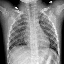

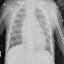

In [3]:
# Preview some images
display(array_to_img(train_images[17]))
array_to_img(train_images[4200])

In [4]:
# Preview the shape of the data
print("Train Data Shape:")
print(np.shape(train_images))
print(np.shape(train_labels))
print("\nTest Data Shape:")
print(np.shape(test_images))
print(np.shape(test_labels))
print("\nValidation Data Shape:")
print(np.shape(val_images))
print(np.shape(val_labels))

Train Data Shape:
(5216, 64, 64, 3)
(5216, 2)

Test Data Shape:
(624, 64, 64, 3)
(624, 2)

Validation Data Shape:
(16, 64, 64, 3)
(16, 2)


In [5]:
# Reshape the train, test, and validation images 
train_img_unrow = train_images.reshape(5216, -1).T
test_img_unrow = test_images.reshape(624, -1).T
val_img_unrow = val_images.reshape(16, -1).T

# Preview the shape of each newly-formed objects
print(np.shape(train_img_unrow))
print(np.shape(test_img_unrow))
print(np.shape(val_img_unrow))

(12288, 5216)
(12288, 624)
(12288, 16)


In [6]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [7]:
# Reshape the label datasets, and select the 'PNEUMONIA' column
train_labels_final = train_labels.T[[1]]
test_labels_final = test_labels.T[[1]]
val_labels_final = val_labels.T[[1]]

# Check the shape of the transformed labels 
print(np.shape(train_labels_final))
print(np.shape(test_labels_final))
print(np.shape(val_labels_final))

(1, 5216)
(1, 624)
(1, 16)


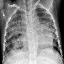

[1.]


In [8]:
# Confirm if the image matches the corresponding label
display(array_to_img(train_images[1400]))
print(train_labels_final[:, 1400])

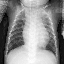

[1.]


In [9]:
# Confirm if the image matches the corresponding label
display(array_to_img(train_images[14]))
print(train_labels_final[:, 14])

In [10]:
# Standardize the datasets
train_img_final = train_img_unrow/255
test_img_final = test_img_unrow/255
val_img_final = val_img_unrow/255

In [11]:
baseline_model = Sequential()
baseline_model.add(Dense(64, activation='relu', input_shape=(5216,)))
baseline_model.add(Dense(2, activation='sigmoid'))

In [12]:
baseline_model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['acc'])

In [13]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                333888    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 334,018
Trainable params: 334,018
Non-trainable params: 0
_________________________________________________________________


In [19]:
baseline_results = baseline_model.fit(train_generator, epochs=24, batch_size=100,
                                      validation_data=(val_img_final, val_labels_final))

Epoch 1/24


ValueError: in user code:

    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\backend.py:4823 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\kaila\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\ops\nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, None, None, 2) vs (None, None))
